
**Final Project - Natural Language Processing QMSS5067**



P0 - Import my drive & libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
import nltk
nltk.download('stopwords')

!pip install vadersentiment

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.3 MB/s 


Define necessary functions

In [ ]:
def clean_text(str_in):
    import re
    sent_a_clean = re.sub("[^A-Za-z']+", " ", str_in) 
    return sent_a_clean

def rem_sw(df_in):
    from nltk.corpus import stopwords
    sw = stopwords.words('english')
    sw.append("xp") #append a keyword to sw
    tmp = [word for word in df_in.split() if word not in sw]
    tmp = ' '.join(tmp)
    return tmp

def my_stem(var_in):
    #stemming
    from nltk.stem.porter import PorterStemmer
    ps = PorterStemmer()
    # example_sentence = "i was hiking down the trail towards by favorite fishing spot to catch lots of fishes"
    ex_stem = [ps.stem(word) for word in var_in.split()]
    ex_stem = ' '.join(ex_stem)
    return ex_stem
    
def count_vec_fun(df_col_in, sw_in, min_in, max_in):
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.feature_extraction.text import CountVectorizer
    import pandas as pd
    if sw_in == "tf-idf":
        cv = TfidfVectorizer(ngram_range=(min_in, max_in))
    else:
        cv = CountVectorizer(ngram_range=(min_in, max_in))
    xform_data = pd.DataFrame(cv.fit_transform(df_col_in).toarray()) #be careful
    #takes up memory when force from sparse to dense
    xform_data.columns = cv.get_feature_names()
    #write_pickle(cv, out_path_in, name_in)
    return xform_data

def chi_fun(df_in, label_in, num_feat):
    #chi-square
    from sklearn.feature_selection import chi2
    from sklearn.feature_selection import SelectKBest
    import pandas as pd
    feat_sel = SelectKBest(score_func=chi2, k=num_feat)
    dim_data = pd.DataFrame(feat_sel.fit_transform(df_in, label_in))
    feat_index = feat_sel.get_support(indices=True)
    feature_names = df_in.columns[feat_index]
    dim_data.columns = feature_names
    #write_pickle(feat_sel, out_path_in, name_in)
    return dim_data


def pca_fun(df_in, exp_var_in):
    #pca
    from sklearn.decomposition import PCA
    import pandas as pd
    dim_red = PCA(n_components=exp_var_in)
    red_data = pd.DataFrame(dim_red.fit_transform(df_in))
    exp_var = sum(dim_red.explained_variance_ratio_)
    print ("Explained variance:", exp_var)
    #write_pickle(dim_red, path_o, name_in)
    return red_data

def vader_senti(str_in):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    senti = SentimentIntensityAnalyzer()
    ex = senti.polarity_scores(str_in)["compound"]
    return ex

def label(score):
    import numpy as np
    if score > 0.5:
      lab = 'StrongBuy'
    elif score < -0.5:
      lab = 'StrongSell'
    elif score > 0:
      lab = 'Buy'
    elif score < 0:
      lab = 'Sell'
    else:
      lab = 'Hold'
    return lab


In [ ]:
# original data lives here: 
# https://www.kaggle.com/datasets/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests?datasetId=754810&select=analyst_ratings_processed.csv
ratings = pd.read_csv('/content/drive/My Drive/Data/analyst_ratings_processed.csv') 
ratings = ratings[ratings['date'] > '2020-01-01 00:00:00-00:00'] 
ratings
#sample = ratings.sample(50000)
#print(sample.shape)


#sample['clean'] = sample.title.apply(clean_text)

#sample['stopwords'] = sample.title.apply(rem_sw)

#sample['stemmed'] = sample.stopwords.apply(my_stem)

#sample['vader'] = sample.stemmed.apply(vader_senti)

#create label based on Vader Sentiment
#sample['label'] = sample.vader.apply(label)

# Compute the mean, median and standard_deviations of vader_senti 
#vader_mean = sample["vader"].mean()
#vader_median = sample["vader"].median()
#vader_std = sample["vader"].std()
  
#sample.to_csv("/content/drive/My Drive/Data/ratings_sample.csv")  
#display(sample)


,Unnamed: 0,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A
...,...,...,...,...
1399473,1412853.0,Shares of several apparel retail and manufactu...,2020-02-03 11:02:00-05:00,ZUMZ
1399474,1412854.0,10 Biggest Price Target Changes For Tuesday,2020-01-14 08:34:00-05:00,ZUMZ
1399475,1412855.0,"Wedbush Maintains Underperform on Zumiez, Rais...",2020-01-14 08:07:00-05:00,ZUMZ
1399476,1412856.0,Zumiez Reports Comparable Sales For Nov. And D...,2020-01-13 16:01:00-05:00,ZUMZ


AttributeError: ignored

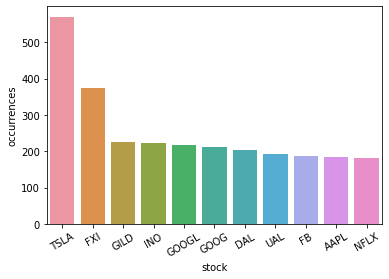

In [ ]:
sample = pd.read_csv("/content/drive/My Drive/Data/ratings_sample.csv")
sample.head()

stock_unique = pd.DataFrame(sample.stock.value_counts().reset_index().values, columns=["stock", "occurrences"])
stocksindex = stock_unique.sort_index(axis = 0, ascending=True)
stock_100 = stock_unique.iloc[:100]

stock_10 = pd.DataFrame(stock_100.head(11))

import matplotlib.pyplot as plt
import seaborn as sns

stocks_10_list = list(stock_10.stock)
plot_count = sns.barplot(data=stock_10, x="stock", y="occurrences").set_xticklabels(stocks_10_list, rotation = 30)
plot_count = plot_count.suptitle("Top 10 Stocks Mentioned")
plot_count


In [ ]:
my_vec = count_vec_fun(sample.stemmed,"vec", 1, 1)
#my_vec.to_csv("/content/drive/My Drive/Data/vectorized_sample.csv")

In [ ]:
sample.label.value_counts()

Hold          24721
Sell          11226
Buy            7932
StrongBuy      4099
StrongSell     2022
Name: label, dtype: int64

In [ ]:
#my_vec = pd.read_csv('/content/drive/My Drive/Data/vectorized_sample.csv') 

Compute heuristic labels based on vader score 

In [ ]:
pca_red = pca_fun(my_vec, 0.95)
display(pca_red)

NameError: ignored

In [ ]:
chi_data = chi_fun(my_vec, sample.label, 1000)
chi_data.to_csv("/content/drive/My Drive/Data/chi_sample.csv")
display(chi_data)

,00,01,03,04,05,06,07,08,09,10,...,worse,worsen,worst,worth,would,wuhan,xeri,yesterday,yoy,zscaler
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
chi_data = pd.read_csv('/content/drive/My Drive/Data/chi_sample.csv') 
sample = pd.read_csv('/content/drive/My Drive/Data/ratings_sample.csv') 

Apply a simple random forrest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd 
from sklearn.model_selection import GridSearchCV


X_train, X_test, y_train, y_test = train_test_split(chi_data, sample.label, test_size= 0.2, random_state=42) 

agg_cnts = pd.DataFrame(y_train).groupby('label')['label'].count()
print (agg_cnts)

model1 =  RandomForestClassifier(criterion = 'gini', max_depth = None, n_estimators = 100, random_state=123)
model1.fit(X_train, y_train)
    
y_pred = model1.predict(X_test)
y_pred_proba = pd.DataFrame(model1.predict_proba(X_test))
y_pred_proba.columns = model1.classes_
    
metrics = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred, average='weighted'))
metrics.index = ["precision", "recall", "fscore", "none"]
print (metrics)


label
Buy            6357
Hold          19537
Sell           9073
StrongBuy      3388
StrongSell     1645
Name: label, dtype: int64
                  0
precision  0.947016
recall     0.946700
fscore     0.946088
none            NaN


In [ ]:
import xgboost as xgb
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

model2 = xgb.XGBRegressor(objective="multi:softmax", num_class = 5, random_state=42)
model2.fit(X_train, y_train)

y_pred2 = model2.predict(X_test)
metrics2 = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred2, average='weighted'))
metrics2.index = ["precision", "recall", "fscore", "none"]
print (metrics2)



                  0
precision  0.845404
recall     0.841500
fscore     0.833807
none            NaN


In [ ]:
#Hyper Parameter Tuning
the_grid = {"n_estimators": [10, 20, 30, 50, 100], "max_depth": [None, 5, 10], "criterion" : ["gini", "entropy", "log_loss"]}
my_grid_model = GridSearchCV(model1, param_grid=the_grid, cv= 5)
my_grid_model.fit(X_train, y_train)
    
print ("Best perf", my_grid_model.best_score_)
print ("Best perf", my_grid_model.best_params_)
    
#my_model = RandomForestClassifier(**my_grid_model.best_params_, random_state=123)


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
75 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", 

Best perf 0.940425
Best perf {'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}


count the stocks with strong buys and buys and sort descending

In [ ]:
def count_buy(series):
    return (series == 'Buy').sum()
def count_strongbuy(series):
    return (series == 'StrongBuy').sum()
def count_sell(series):
    return (series == 'Sell').sum()
def count_strongsell(series):
    return (series == 'StrongSell').sum()
def count_hold(series):
    return (series == 'Hold').sum()

buys = sample.groupby(by=["stock"])['label'].apply(count_buy).reset_index(name='buy')
strongbuys = sample.groupby(by=["stock"])['label'].apply(count_strongbuy).reset_index(name='strongbuy')
sells = sample.groupby(by=["stock"])['label'].apply(count_sell).reset_index(name='sell')
strongsells = sample.groupby(by=["stock",])['label'].apply(count_strongsell).reset_index(name='strongsell')
holds = sample.groupby(by=["stock"])['label'].apply(count_hold).reset_index(name='hold')


In [ ]:

forecast = pd.concat([buys, strongbuys,sells,strongsells,holds],join='outer', axis=1)
forecast = forecast.loc[:,~forecast.columns.duplicated()].copy()
forecast['BuySignal'] = forecast.apply(lambda x: x['buy'] + x['strongbuy'] * 1.33, axis=1)
forecast['SellSignal'] = forecast.apply(lambda x: x['sell'] + x['strongsell'] * 1.33, axis=1)
forecast['StockSentiment'] = fpply(laorecast.ambda x: x['BuySignal'] - x['SellSignal'], axis=1)
forecast = forecast.sort_values(by = ['StockSentiment'], ascending = [False])
forecast = forecast.reset_index()
forecast = forecast.drop(['index'], axis=1)
#forecast.to_csv("/content/drive/My Drive/Data/portfolio_forecast.csv")
display(forecast.head(10))

,stock,buy,strongbuy,sell,strongsell,hold,BuySignal,SellSignal,StockSentiment
0,TSLA,119,49,59,26,317,184.17,93.58,90.59
1,GILD,83,11,26,2,103,97.63,28.66,68.97
2,AMZN,70,12,16,5,57,85.96,22.65,63.31
3,NFLX,40,25,19,6,91,73.25,26.98,46.27
4,GOOGL,46,28,32,8,102,83.24,42.64,40.60
5,NVDA,29,22,14,5,87,58.26,20.65,37.61
6,BAC,23,23,16,5,37,53.59,22.65,30.94
7,MS,32,20,22,5,50,58.60,28.65,29.95
8,FB,41,14,27,4,101,59.62,32.32,27.30
9,MRVL,21,11,5,3,16,35.63,8.99,26.64


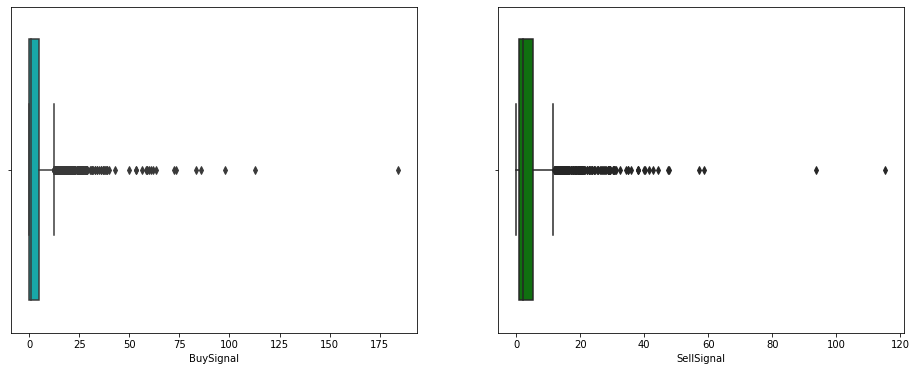

In [ ]:
# simple visualization for the forecast
import seaborn as sns

# boxplot of BuySignal and SellSignal
fig, ax = plt.subplots(1, 2, figsize = (16, 6));
sns.boxplot(x = forecast.BuySignal, ax = ax[0], color = 'c');
sns.boxplot(x = forecast.SellSignal, ax = ax[1], color = 'g');

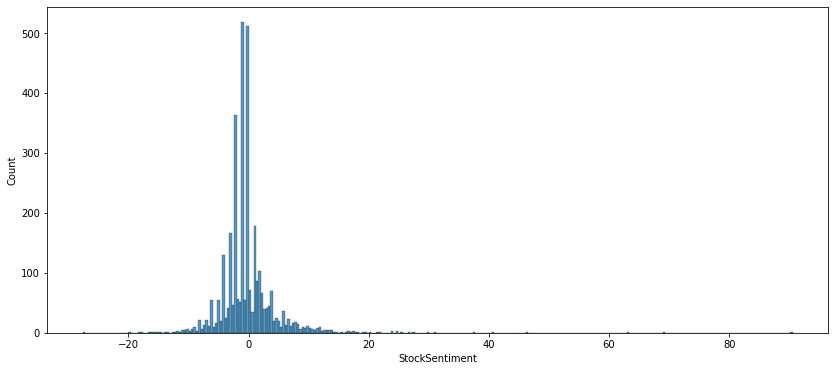

In [ ]:
# plot the distribution of StockSentiment
fig, ax = plt.subplots(1, 1, figsize = (14, 6));
sns.histplot(x = forecast.StockSentiment);

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


TSLA     570
FXI      373
GILD     225
INO      222
GOOGL    216
        ... 
DXYN       1
PMF        1
ACUR       1
EWO        1
WMC        1
Name: stock, Length: 3331, dtype: int64

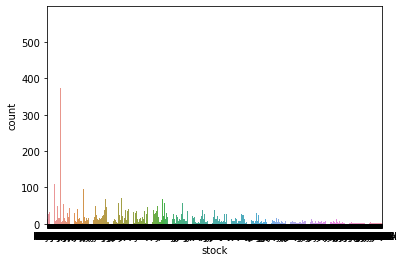

In [ ]:
# count and visulize the data volume of each stock
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot('stock', data=sample)
sample['stock'].value_counts()

##Stock Price Prediction

We’ve got top ten stocks with positive sentimental scores. In this part, we will try to predict the stock price in the following half a year. 

Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. A time-series is a series of data points indexed in time order and it is used to predict the future based on the previous observed values. Time series are very frequently plotted via line charts. Time series are used in statistics, weather forecasting, stock price prediction, pattern recognition, earthquake prediction, e.t.c. Time series forecasting is the use of a model to predict future values based on previously observed values. 

In this part, we will tackle different topics concerning data science in the stock price predictions, like data extraction and cleaning, data processing, as well as the creation of machine learning models to make predictions.

###Extract stock data

Yahoo Finance is one of the widely used platforms that provides stock market data. We can easily download the dataset from their website, and can access it directly from a Python program with yfinance library. By set the start date and end date, we can easily get the data between the time range.

The date of the earliest historic data of these top ten stocks we can extract is 2012-06-01. Therefore, we will extract historic stock price data between 2012-06-01 and today to train the price prediction model. we can get the daily open, high, low, close, adjusted close price and transaction volume data.

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
def stock_data(name_in, start_date, end_date):
    # name_in: the stock ticker
    # start_date/end_date: format example: '2018-01-01'

    import yfinance as yf
    import pandas as pd

    # Set the start and end date
    s_date = start_date 
    e_date = end_date 

    # Set the ticker
    ticker = name_in

    # Get the data
    data = yf.download(ticker, s_date, e_date)

    data.reset_index('Date',inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return(data)

###EDA for stock data

In [ ]:
def stock_eda(df_in):
    import matplotlib.pyplot as plt
    
    data = df_in
    plt.figure(figsize=(11, 8)) # resizing the plot
    data['Adj Close'].plot()
    plt.title('Closing Price History') # adding a title
    plt.xlabel('Date') # x label
    plt.ylabel('Closing Price') # y label
    plt.show()
    
    plt.figure(figsize=(16, 8)) # resizing the plot
    cols = ['Open', 'Close', 'Volume', 'High', 'Low']
    axes = data[cols].plot(figsize=(11, 9), subplots = True)
    plt.show()

###Data Processing


Due to the high correlation, We have to add some features to the dataset. 

* HL_PCT calculates the difference percentage between the highest price and the lowest for each day;
* PCT_change is the difference percentage between the open and the close price for each day. 

We will use these two features and feature 'Adj Close', and feature 'Volume' to train our model.

we will also scale the data between -1 and 1 in order to put all columns in the data set in the same range. 
Before we train the model, we need to split the data to train set and test set with cross validation, so we can use the test set to evaluate the accuracy and compare model’s performances. 

In [ ]:
def feature_df(df_in, forecast_percent):
    import math
    import warnings
    warnings.filterwarnings("ignore") 
    train_data = df_in
    train_data['HL_PCT'] = (train_data['High'] - train_data['Low']) / train_data['Low'] * 100.0
    train_data['PCT_change'] = (train_data['Close'] - train_data['Open']) / train_data['Open'] * 100.0
    df = train_data[['HL_PCT', 'PCT_change', 'Adj Close','Volume']]
    forecast_out = int(math.ceil(forecast_percent * len(df))) # forcasting out forecast_percent of the entire dataset
    df['label'] = df['Adj Close'].shift(-forecast_out)
    return df,forecast_out 
def feature_df_o(df_in, forecast_percent):
    import math
    import warnings
    warnings.filterwarnings("ignore") 
    train_data = df_in
    train_data['HL_PCT'] = (train_data['High'] - train_data['Low']) / train_data['Low'] * 100.0
    train_data['PCT_change'] = (train_data['Close'] - train_data['Open']) / train_data['Open'] * 100.0
    df = train_data[['HL_PCT', 'PCT_change', 'Adj Close','Volume']]
    forecast_out = int(math.ceil(forecast_percent * len(df))) # forcasting out forecast_percent of the entire dataset
    df['label'] = df['Adj Close']
    return df,forecast_out

###Example
take stock 'MRK' during '2018-01-01' and '2020-12-31' and 10% prediction percentage to do the demo

In [ ]:
## Data Vis ##
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
## load dataset

df = pd.read_csv('/content/drive/My Drive/Data/analyst_ratings_processed.csv')
df = df.drop("Unnamed: 0", axis = 1)

In [ ]:
## get value counts for each stock, select top 100

stocks = pd.DataFrame(df.stock.value_counts().reset_index().values, columns=["stock", "occurrences"])
stocksindex = stocks.sort_index(axis = 0, ascending=True)
stocks_100 = stocks.iloc[:100]

In [ ]:
## wrote an .xlsx for top 100 mentioned stocks; then manually inserted industry type

stocks_100 = pd.read_excel('/content/drive/My Drive/stocks_100.xlsx')
stocks_100 = stocks_100.drop("Unnamed: 0", axis = 1)

FileNotFoundError: ignored

In [ ]:
## created list of top 100 stocks to reference original dataset, select only stocks found in list of top 100

ticker_100 = stocks_100['Stock'].tolist()
df_100 = df[df['stock'].isin(ticker_100)]

In [ ]:
## result is ~200,000 obs; data frame called df_100 (you can access the data set below)

  # df_100["stopwords"] = df_100.title.apply(rem_sw)
  # df_100["stemmed"] = df_100.stopwords.apply(my_stem)

In [ ]:
## instead of loading yourself, here's the df_100.xlsx:

df_100 = pd.read_excel('/content/drive/My Drive/df_100.xlsx')

In [ ]:
## import VaderSentiment

def vader_senti(str_in):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    senti = SentimentIntensityAnalyzer()
    ex = senti.polarity_scores(str_in)["compound"]
    return ex

## vader column already loaded above
  # df_100['vader'] = df_100.stemmed.apply(vader_senti)

In [ ]:
## sort stocks_100 alphabetically so df_100['vader'] can be bound to stocks_100; then find mean, med, std of vader for each stock

stocks_100 = stocks_100.sort_values("Stock", ascending = True)

stocks_100['Average VaderSentiment'] = list(df_100.groupby('stock')["vader"].mean())
stocks_100['Median VaderSentiment'] = list(df_100.groupby('stock')["vader"].median())
stocks_100['Std. VaderSentiment'] = list(df_100.groupby('stock')["vader"].std())

In [ ]:
## boxplot of average vader_senti score per industry
boxplot = sns.boxplot("Industry", "Average VaderSentiment", data = stocks_100)
Industry = list(stocks_100["Industry"].unique())
boxplot = sns.boxplot("Industry", "Average VaderSentiment", data = stocks_100).set_xticklabels(Industry, rotation = 30, horizontalalignment = "right")

In [ ]:
## scatterplot of stocks by average vader_senti grouped by industry
## !! had trouble finding a solution to move the legend out of the plot and to the side, stackoverflow and other websiters weren't a big help...

fig, ax = plt.subplots()
sns.scatterplot("Occurrences", "Average VaderSentiment", hue = "Industry", data = stocks_100)
leg = plt.legend(loc = "upper right", bbox_to_anchor=(1.35, 1))
plt.show()


In [ ]:
# get the data
train_data = stock_data('MRK','2018-01-01','2020-12-31')
train_data.tail()

In [ ]:
# EDA of stock data
stock_eda(train_data)

###Automatic model selection and prediction


For each stock, we are going to try different machine learning models, including: linear regression, random forest, ridge and support vector regression. 
* Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data; 
* Ridge regression is a method of estimating the coefficients of multiple-regression models in scenarios where the independent variables are highly correlated; 
* Random Forest Regression is a supervised learning algorithm that uses ensemble learning method for regression; 
* SVM regression is a nonparametric regression relying on kernel functions. 

Different model has different performance on different data, therefore, picking the best model with highest prediction accuracy for each stock data is see important.

For example, for the Tesla stock, the best model is random forest with accuracy 0.93.

In [ ]:
def model_predict(stock_name, data_in,forecast_percent):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import datetime
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression, Ridge
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.svm import SVR
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_log_error
    
    df,forecast_out = feature_df(data_in,0.08)
    df_o,forecast_out = feature_df_o(data_in,0.08)
    #scale the data
    scaler = StandardScaler()
    X = np.array(df.drop(['label'], 1))
    scaler.fit(X)
    X = scaler.transform(X)
    
    #pick data to be predicted
    X_Predictions = X[-forecast_out:] # data to be predicted
    X = X[:-forecast_out] # data to be trained

    #get the target value
    df.dropna(inplace=True)
    y = np.array(df['label'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    #linear regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_confidence = lr.score(X_test, y_test)
    
    #random forest
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    rf_confidence = rf.score(X_test, y_test)
    
    #ridge
    rg = Ridge()
    rg.fit(X_train, y_train)
    rg_confidence = rg.score(X_test, y_test)
    
    #svr
    svr = SVR()
    svr.fit(X_train, y_train)
    svr_confidence = svr.score(X_test, y_test)
    
    names = ['Linear Regression', 'Random Forest', 'Ridge', 'SVR']
    columns = ['model', 'accuracy']
    scores = [lr_confidence, rf_confidence, rg_confidence, svr_confidence]
    alg_vs_score = pd.DataFrame([[x, y] for x, y in zip(names, scores)], columns = columns)
    #print(alg_vs_score)
    #sns.barplot(data = alg_vs_score, x='model', y='accuracy' )
    #plt.title('Performance of Different Models')
    #plt.xticks(rotation='vertical')
    final_model = alg_vs_score['model'][alg_vs_score['accuracy'].idxmax()]
    print('best model for ', stock_name, ' is ',final_model)
    
    if final_model=='Linear Regression':
        model = lr
    elif final_model=='Random Forest':
        model = rf
    elif final_model=='Ridge':
        model = rg
    else:
        model = svr  
    
    last_date = df_o.index[-1] #getting the lastdate in the dataset
    last_unix = last_date.timestamp() #converting it to time in seconds
    one_day = 86400 #one day equals 86400 seconds
    next_unix = last_unix + one_day # getting the time in seconds for the next day
    forecast_set = model.predict(X_Predictions) # predicting forecast data
    df_o['Forecast'] = np.nan
    for i in forecast_set:
        next_date = datetime.datetime.fromtimestamp(next_unix)
        next_unix += 86400
        df_o.loc[next_date] = [np.nan for _ in range(len(df_o.columns)-1)]+[i]
    plt.figure(figsize=(18, 8))
    df_o['Adj Close'].plot()
    df_o['Forecast'].plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()
    volat_percent = round(((forecast_set[len(forecast_set)-1]-forecast_set[0])/forecast_set[len(forecast_set)-1])*100,2)
    print('the volatility percent of ', stock_name, ' during the prediction period is ',volat_percent, '%.')
    return(df_o)

For the next step, we can use the best model to make the future price predictions. Our model predict from December 2022 to July 2023, the trend for Tesla will be like this plot, and the volatility during the prediction duration is about 23%. 

[*********************100%***********************]  1 of 1 completed
best model for  TSLA  is  Random Forest


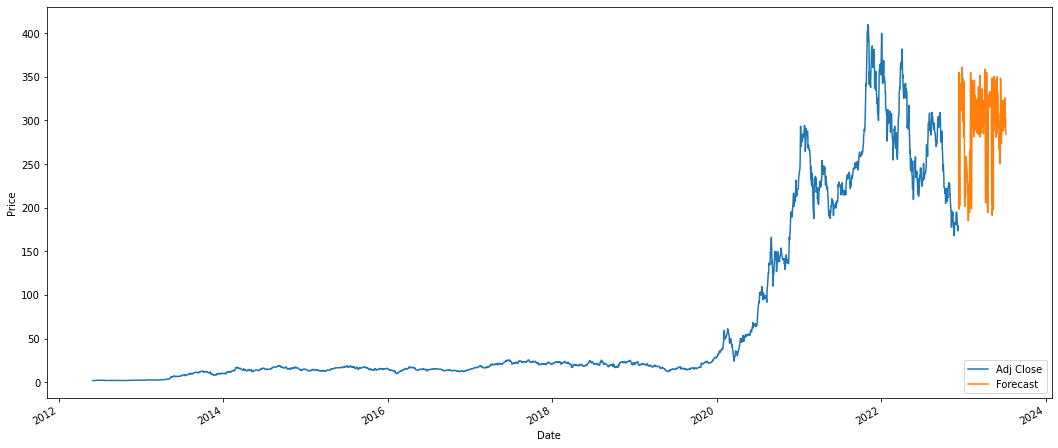

the volatility percent of  TSLA  during the prediction period is  28.05 %.
[*********************100%***********************]  1 of 1 completed
best model for  GILD  is  Random Forest


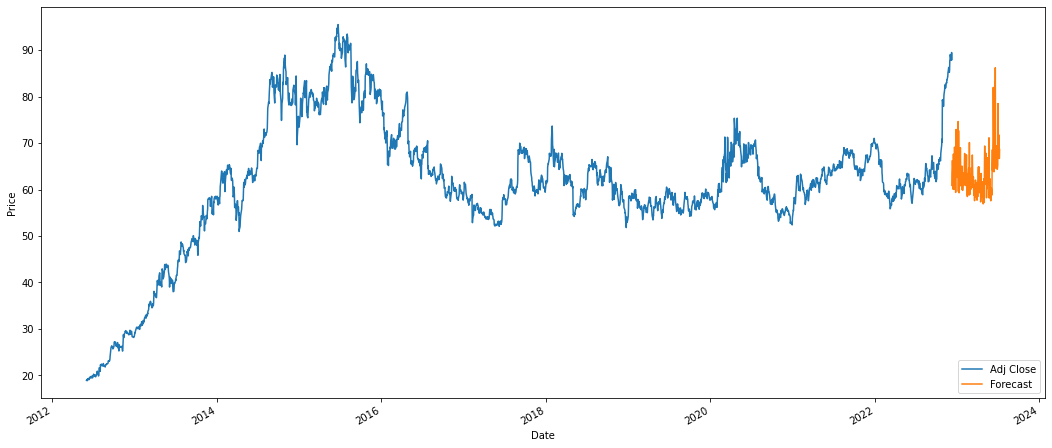

the volatility percent of  GILD  during the prediction period is  3.64 %.
[*********************100%***********************]  1 of 1 completed
best model for  AMZN  is  Random Forest


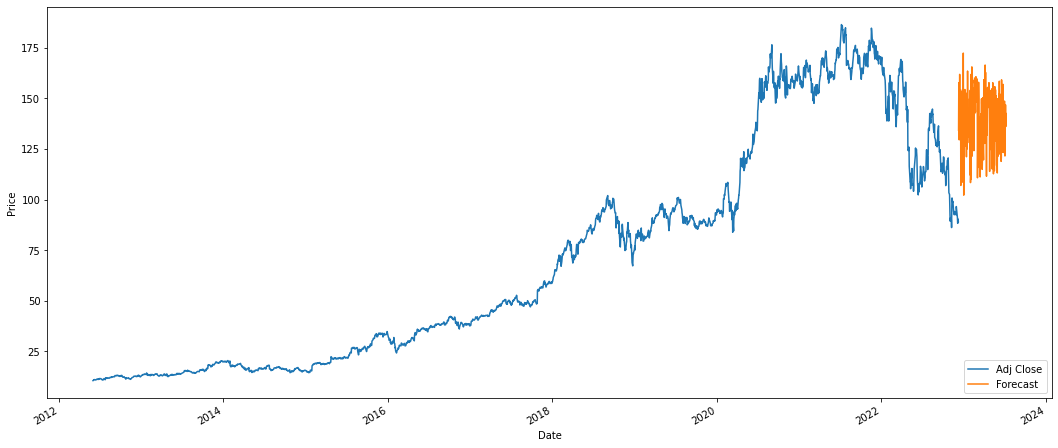

the volatility percent of  AMZN  during the prediction period is  5.76 %.
[*********************100%***********************]  1 of 1 completed
best model for  NFLX  is  Random Forest


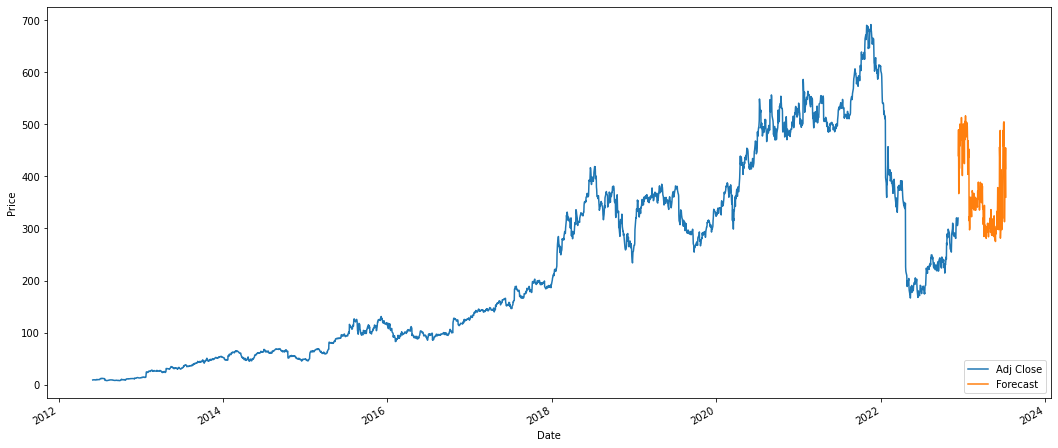

the volatility percent of  NFLX  during the prediction period is  -22.1 %.
[*********************100%***********************]  1 of 1 completed
best model for  GOOGL  is  Random Forest


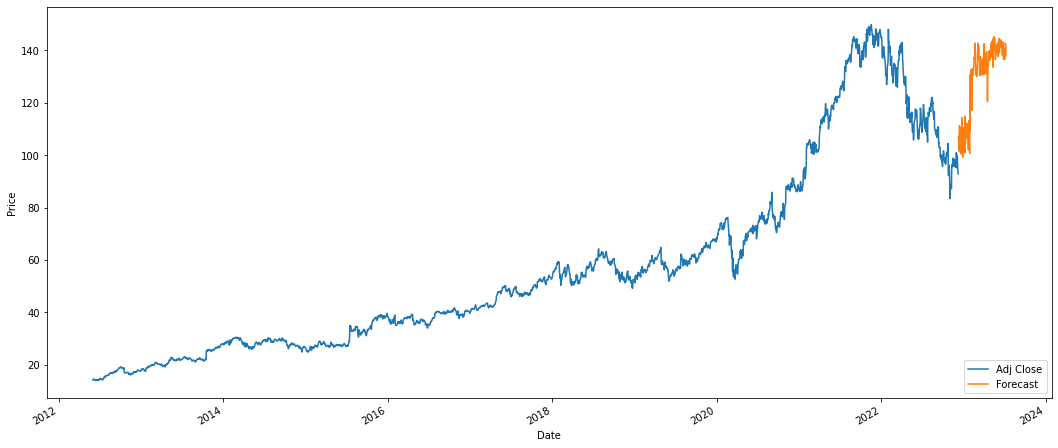

the volatility percent of  GOOGL  during the prediction period is  22.93 %.
[*********************100%***********************]  1 of 1 completed
best model for  NVDA  is  Random Forest


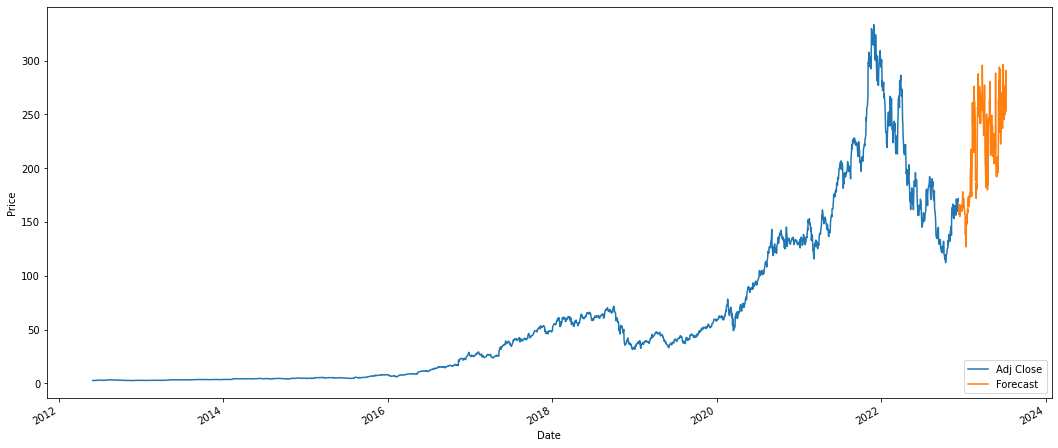

the volatility percent of  NVDA  during the prediction period is  36.84 %.
[*********************100%***********************]  1 of 1 completed
best model for  BAC  is  Random Forest


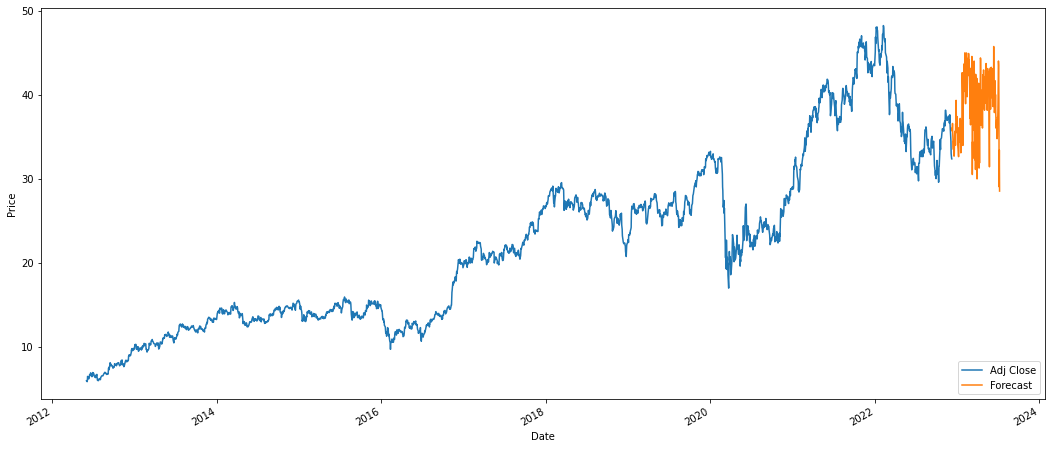

the volatility percent of  BAC  during the prediction period is  -26.21 %.
[*********************100%***********************]  1 of 1 completed
best model for  MS  is  Random Forest


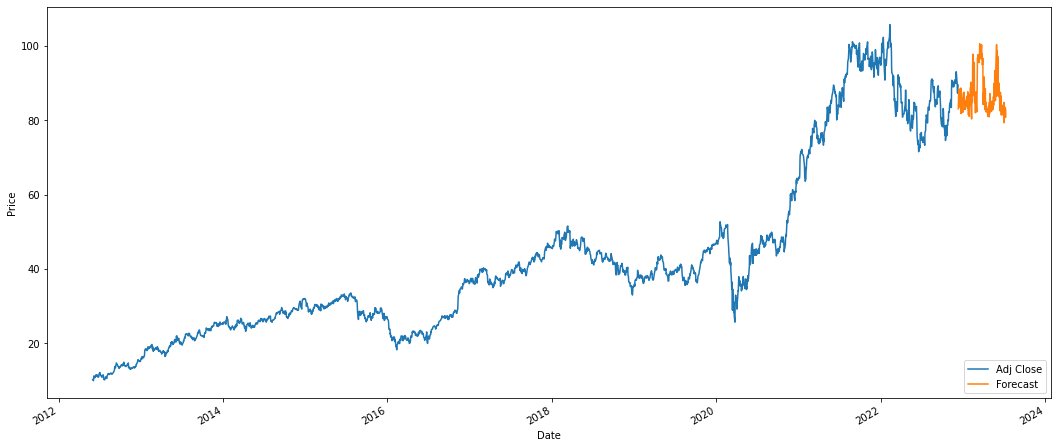

the volatility percent of  MS  during the prediction period is  -2.64 %.
[*********************100%***********************]  1 of 1 completed
best model for  META  is  Random Forest


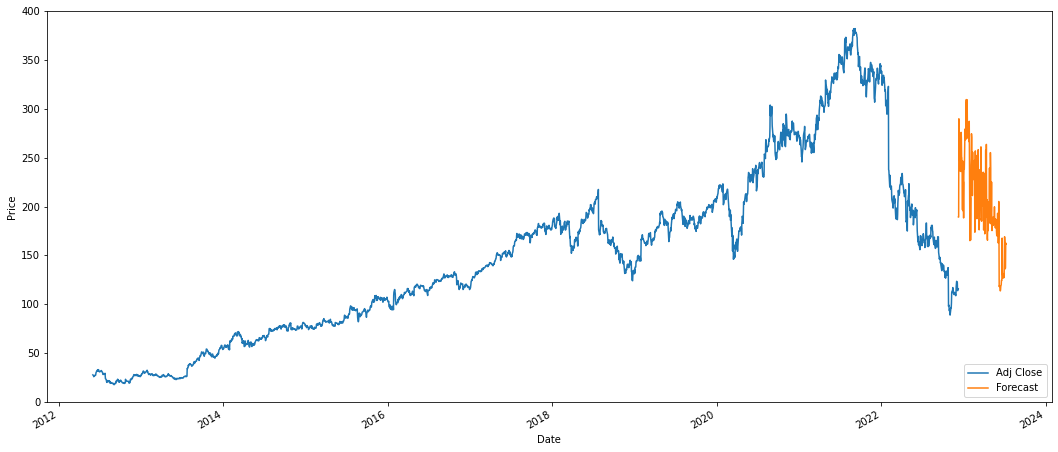

the volatility percent of  META  during the prediction period is  -17.13 %.
[*********************100%***********************]  1 of 1 completed
best model for  MRVL  is  Random Forest


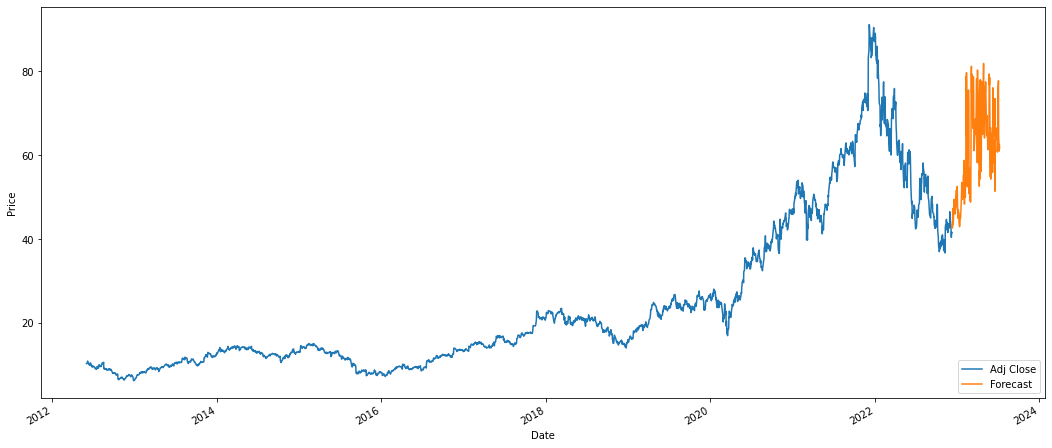

the volatility percent of  MRVL  during the prediction period is  29.67 %.
                  TSLA       GILD        AMZN        NFLX       GOOGL  \
2022-12-10  204.529901  66.105417  134.321371  439.896002  106.411671   
2022-12-11  207.707801  60.767489  154.964244  489.724101  107.223965   
2022-12-12  198.387836  63.491513  157.863926  366.932005  101.575584   
2022-12-13  355.063233  64.658630  129.527389  455.981599  106.095030   
2022-12-14  335.313436  61.936208  142.813189  466.767196  111.272055   
...                ...        ...         ...         ...         ...   
2023-07-05  324.645065  68.318519  138.157529  368.976901  140.644192   
2023-07-06  292.323468  70.807368  146.634283  448.623203  142.805044   
2023-07-07  302.463501  71.699285  146.804888  413.654600  142.663659   
2023-07-08  287.858035  66.669581  136.143145  454.931302  142.208464   
2023-07-09  284.271169  68.602859  142.524968  360.277299  138.070350   

                  NVDA        BAC         MS    

In [ ]:
stock_list = ['TSLA','GILD','AMZN','NFLX','GOOGL','NVDA','BAC','MS','META','MRVL']
start_date = '2012-06-01'
end_date = '2022-12-31'
forecast_percent = 0.05

for stock in stock_list:
    import pandas as pd
    train_data = stock_data(stock,start_date,end_date)
    data = model_predict(stock,train_data,forecast_percent)
    if stock_list.index(stock) == 0:
        forecast_df = pd.DataFrame(data.loc[-data.iloc[:,5].isnull(),'Forecast'])
        forecast_df.columns = [stock]
    else:
        forecast_df[stock] = pd.DataFrame(data.loc[-data.iloc[:,5].isnull(),'Forecast'])

forecast_df.index = forecast_df.index.date
print(forecast_df)

##Portfolio Optimization
Portfolio optimization is the process of selecting the best portfolio, out of the set of all portfolios being considered, according to some objective. The objective typically maximizes factors such as expected return, and minimizes costs like financial risk. Finding the right methods for portfolio optimization is an important part of the work done by investment banks and asset management firms.

###Mean Variance Optimization
* One of the early methods is called mean variance optimization, it works by assuming investors are risk-averse. 
* Specifically, it selects a set of assets that are least correlated (i.e., different from each other) and that generate the highest returns. 

In [ ]:
#  implement the mean variance optimization method to construct our portfolio
!pip install PyPortfolioOpt

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

# alculate the covariance matrix and store the calculated returns in variables S and mu, respectively

#**need the result portfolio dataset**
mu = mean_historical_return(forecast_df)
S = CovarianceShrinkage(forecast_df).ledoit_wolf()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 466 kB/s 
     |████████████████████████████████| 17.1 MB 7.5 MB/s 
     |████████████████████████████████| 16.9 MB 60.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6


In [ ]:
# import the EfficientFrontier module and calculate the weights
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S, weight_bounds = (0, 0.20)) # add weight_bounds up to 20%
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

# display portfolio performance
ef.portfolio_performance(verbose=True) # expected annual return, anuual volatility, sharp ratio

{'TSLA': 0.09209, 'GILD': 0.15575, 'AMZN': 0.1027, 'NFLX': 0.0, 'GOOGL': 0.2, 'NVDA': 0.2, 'BAC': 0.0, 'MS': 0.06271, 'META': 0.00976, 'MRVL': 0.177}
Expected annual return: 36.7%
Annual volatility: 63.1%
Sharpe Ratio: 0.55


(0.3670163352695929, 0.6313622340986996, 0.5496311254108754)

In [ ]:
# convert the weights into actual allocations values (i.e., how many of each stock to buy)
# for our allocation, let’s consider an investment amount of $100,000
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(forecast_df)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation) # stocks and shares
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'GOOGL': 144, 'NVDA': 79, 'MRVL': 287, 'GILD': 227, 'AMZN': 72, 'TSLA': 33, 'MS': 77, 'META': 6}
Funds remaining: $1.50


Mean variance optimization doesn’t perform very well since it makes many simplifying assumptions, such as returns being normally distributed and the need for an invertible covariance matrix. Fortunately, methods like HRP and mCVAR address these limitations. 



### Hierarchical Risk Parity (HRP)
* The HRP method works by finding subclusters of similar assets based on returns and constructing a hierarchy from these clusters to generate weights for each asset. 
* HRP is not as sensitive to outliers as mean variance optimization is.

In [ ]:
from pypfopt import HRPOpt

# calculate the returns
returns = forecast_df.pct_change().dropna()

# run the optimization algorithm to get the weights
hrp = HRPOpt(returns)
hrp_weights = hrp.optimize()

# print the performance of the portfolio and the weights
hrp.portfolio_performance(verbose=True)
print(dict(hrp_weights))

Expected annual return: 64.7%
Annual volatility: 37.4%
Sharpe Ratio: 1.68
{'AMZN': 0.022859404402212055, 'BAC': 0.06551061938097193, 'GILD': 0.11822872574862987, 'GOOGL': 0.24467823186811177, 'META': 0.03774002074255751, 'MRVL': 0.02395921159703334, 'MS': 0.40062066365816823, 'NFLX': 0.035669073398987464, 'NVDA': 0.03475377319142169, 'TSLA': 0.015980276011906224}


In [ ]:
# calculate the discrete allocation using our weights
da_hrp = DiscreteAllocation(hrp_weights, latest_prices, total_portfolio_value=100000)

allocation, leftover = da_hrp.greedy_portfolio()
print("Discrete allocation (HRP):", allocation)
print("Funds remaining (HRP): ${:.2f}".format(leftover))

Discrete allocation (HRP): {'MS': 494, 'GOOGL': 177, 'GILD': 172, 'BAC': 230, 'META': 23, 'NFLX': 10, 'NVDA': 14, 'MRVL': 38, 'AMZN': 16, 'TSLA': 6}
Funds remaining (HRP): $18.04


### Mean Conditional Value at Risk (mCVAR)
* The mCVAR is another popular alternative to mean variance optimization. It works by measuring the worst-case scenarios for each asset in the portfolio, which is represented here by losing the most money.
* The worst-case loss for each asset is then used to calculate weights to be used for allocation for each asset.

In [ ]:
from pypfopt.efficient_frontier import EfficientCVaR

# calculate the weights and get the performance
S = forecast_df.cov()
ef_cvar = EfficientCVaR(mu, S, weight_bounds = (0, 0.20)) # add weight_bounds up to 20%
cvar_weights = ef_cvar.min_cvar()

cleaned_weights = ef_cvar.clean_weights()
print(dict(cleaned_weights))

# get the discrete allocation
da_cvar = DiscreteAllocation(cvar_weights, latest_prices, total_portfolio_value=1000000) # assume we have $1million to allocate

allocation, leftover = da_cvar.greedy_portfolio()
print("Discrete allocation (CVAR):", allocation) # didn't use, use toatal amount (1 million * weights instead)
print("Funds remaining (CVAR): ${:.2f}".format(leftover))

{'TSLA': 0.2, 'GILD': 0.2, 'AMZN': 0.15749, 'NFLX': 0.04981, 'GOOGL': 0.0, 'NVDA': 0.11305, 'BAC': 0.2, 'MS': 0.0, 'META': 0.07966, 'MRVL': 0.0}
Discrete allocation (CVAR): {'BAC': 7007, 'GILD': 2915, 'TSLA': 703, 'AMZN': 1105, 'NVDA': 446, 'META': 493, 'NFLX': 139}
Funds remaining (CVAR): $1.85


In [ ]:
display(list(allocation.keys()))
cleaned_weights.values()

y = list(cleaned_weights.values())
y = list(filter(lambda num: num != 0, y))
y # len(y) = 7

['BAC', 'GILD', 'TSLA', 'AMZN', 'NVDA', 'META', 'NFLX']

[0.2, 0.2, 0.15749, 0.04981, 0.11305, 0.2, 0.07966]

### Visualization for allocations
*Since the predicted stock price varies every day, we used the most current (2023-07-09) stock price to do the visualization.*

In [ ]:
# get color palette
import seaborn as sns

palette = sns.color_palette("Pastel1", 7).as_hex()
print(palette)

['#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6', '#ffffcc', '#e5d8bd']


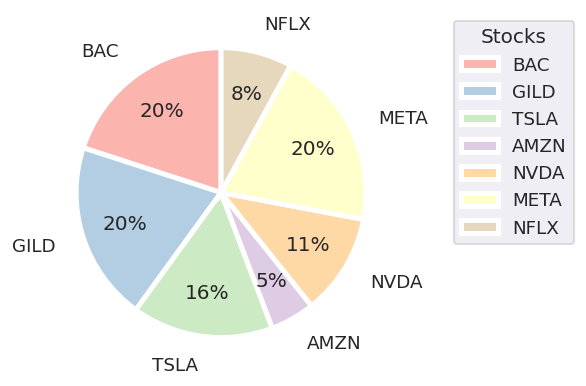

In [ ]:
# pie plot for weights
import matplotlib.pyplot as plt
import numpy as np
# set plot resolution
sns.set(rc={"figure.dpi":120, 'savefig.dpi':300})

# specify y and labels
y = list(dict(cleaned_weights).values())
y = list(filter(lambda num: num != 0, y))
stock_list = list(allocation.keys())

# pie plot
plt.pie(y, labels = stock_list, startangle = 90, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, colors = palette,
        autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.2)
plt.legend(title = "Stocks", loc = "upper right", bbox_to_anchor = (1.50, 1))
plt.show() 

# save the plot
#save_results_to = '/content/drive/My Drive/'
#plt.savefig(save_results_to + 'stock_weights.pdf')

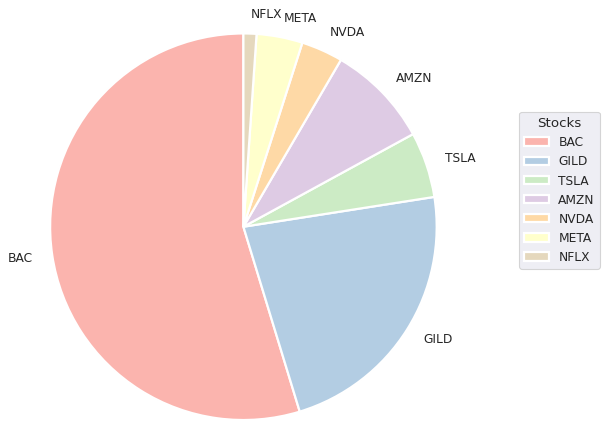

In [ ]:
# pie plot for shares
# set plot resolution
import numpy as np
sns.set(rc={"figure.dpi":80, 'savefig.dpi':300})

# specify y and labels
y = list(allocation.values())

# define a function to show acutal value
def absolute_value(val):
    a  = np.round(val/100.*np.array(y).sum(), 0)
    return a

# pie plot
plt.pie(y, labels = stock_list, startangle = 90, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' }, colors = palette, labeldistance=1.1, 
        radius = 2, pctdistance=0.7)
        # autopct=absolute_value
        #rotatelabels = .5
plt.legend(title = "Stocks", loc = "upper right", bbox_to_anchor = (2, 1))\

#for label, pct_text in zip(labels, pct_texts):
    #pct_text.set_rotation(label.get_rotation())

plt.show() 

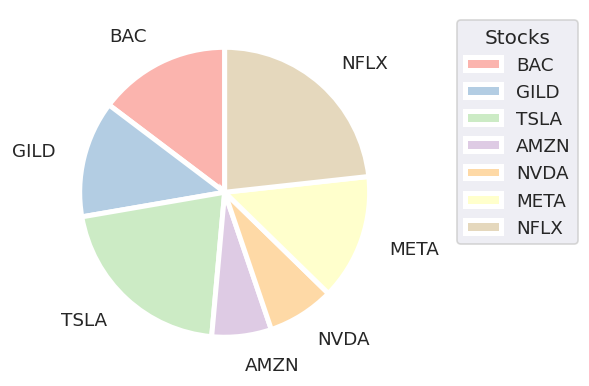

In [ ]:
# pie plot for allocation in dollar values
# set plot resolution
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.dpi":120, 'savefig.dpi':300})
palette = sns.color_palette("Pastel1", 7).as_hex()

# specify y and labeles
# y: forecasted portfolio = forecasted rice * number of shares
# use hard code here to sotre the result we extracted on 12/11/2022
stock_list = ['BAC', 'GILD', 'TSLA', 'AMZN', 'NVDA', 'META', 'NFLX']
y = [176301.71, 155968.76, 250041.14, 79685.36, 89683.73, 168380.70,  278870.06] # forcasted portfolio value
# pie plot
plt.pie(y, labels = stock_list, startangle = 90, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, colors = palette, labeldistance=1.2)
plt.legend(title = "Stocks", loc = "upper right", bbox_to_anchor = (1.50, 1))
plt.show() 

# save the plot
#save_results_to = '/content/drive/My Drive/'
#plt.savefig(save_results_to + 'stock_weights.pdf')